In [13]:
basedir='/hirax/GBO_Analysis_Outputs/'
ampdir = basedir+'amplitude_corrections/'
ampls = 1.0*np.ones([4,1024,16])
pklfile = ampdir+'FLY620_Corrected_amplitudes.pkl'
with open(pklfile, 'wb') as outp:
            pickle.dump(ampls, outp, pickle.HIGHEST_PROTOCOL)

In [14]:
# practice the script

## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

sz = 80


def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f


with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

for find in good_freqs[115:116]:
    print('Working on Frequency: ',find,freqs[find])
    
    flights = Epolflights
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]    

    beam=ba.Beammap_newnew(concatlist=concytest,
                 coordsys='polar',normalization='Gauss_wcorr',operation='std',Fargs=[find,find+1,1],
                    f_index=find,vplot=False,mask=True)

    thingy = rc.Smallify_comap(beam)
    for j,fstr in enumerate(documents['flight_info']['flights']):
        if beam.FLYNUM in fstr:
            copoldir=documents['flight_info']['pols'][j]
    print(copoldir)
    #write_pickle = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'

    #print(write_pickle)
    #with open(write_pickle, 'wb') as outp:
    #    pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
    print('DONE')
print('For loop ended successfully')

Working on Frequency:  900 448.4375
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY648_20211022T191922Z_ver_20231012T031117_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY649_20211022T194308Z_ver_20231012T033021_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY535_20210826T192056Z_ver_20231011T234909_concat.pkl
start of big ass loop is: 2023-11-21 23:18:05.974367
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
648 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz
649 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz
535 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2023-11-21 23:18:22.489127          
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T

<ipython-input-15-a67f101eac80>:7: RuntimeWarning: divide by zero encountered in log10
  c=10*np.log10(np.abs(beam.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')


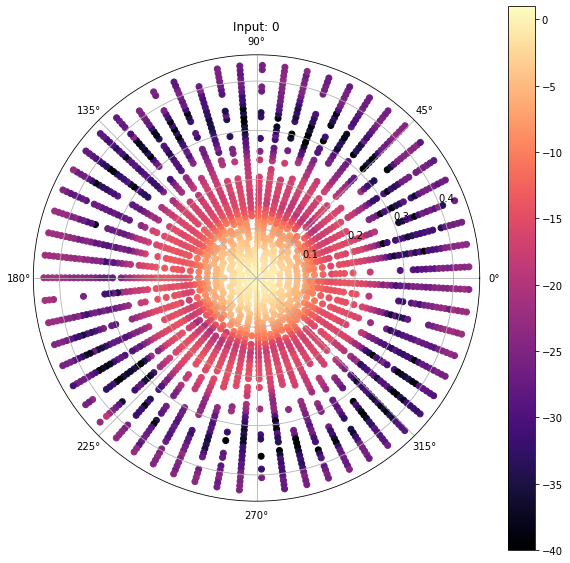

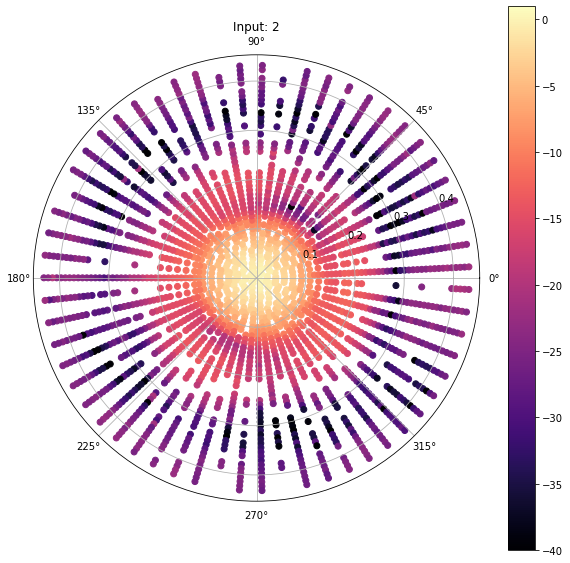

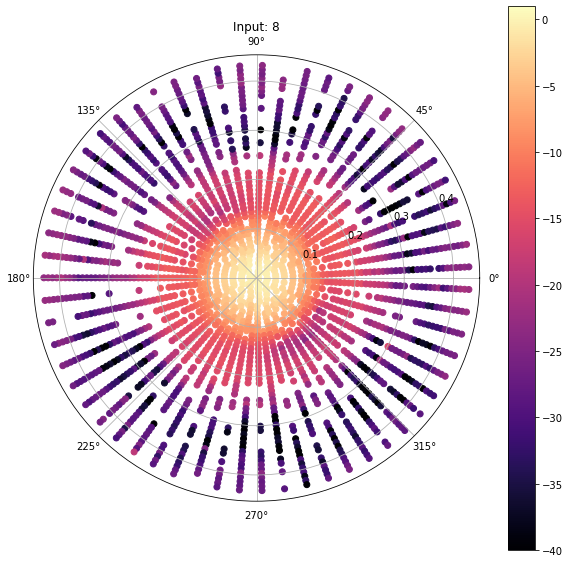

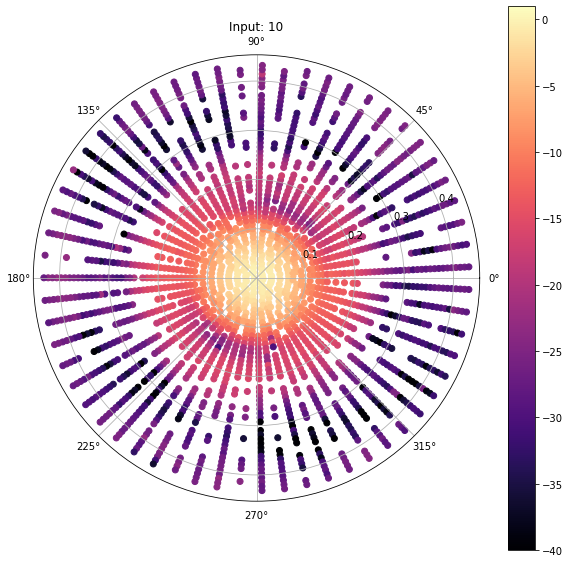

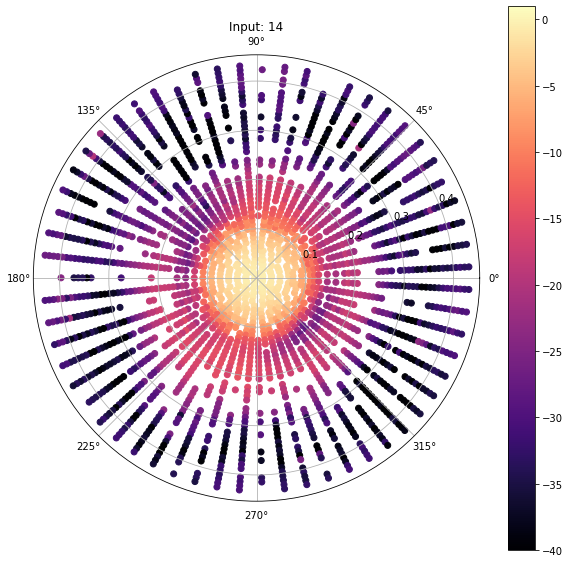

In [15]:
for i,chind in enumerate(E_pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=10*np.log10(np.abs(beam.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

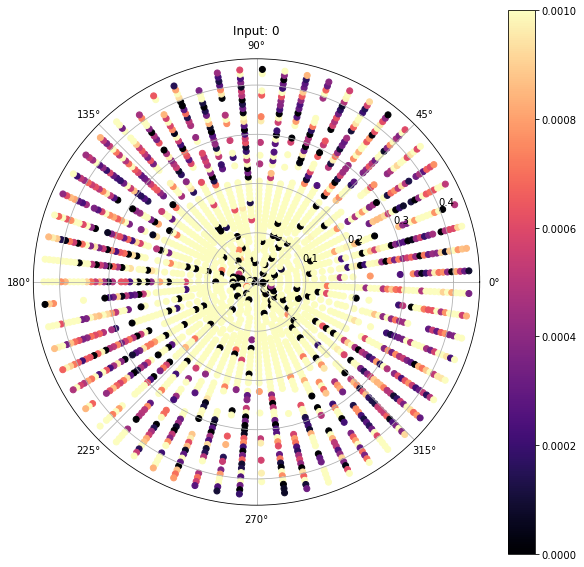

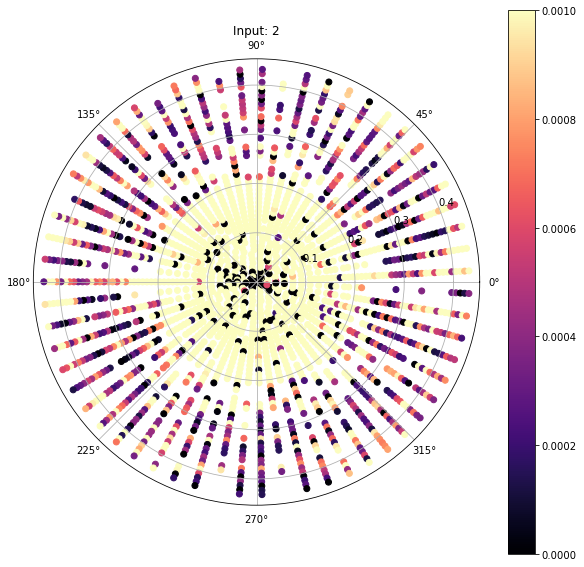

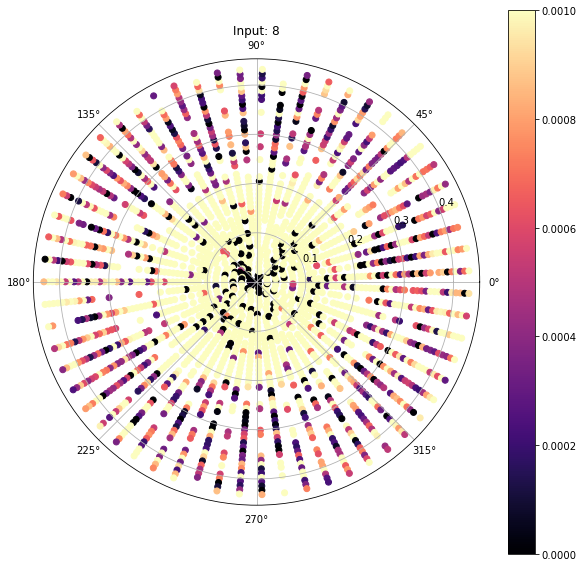

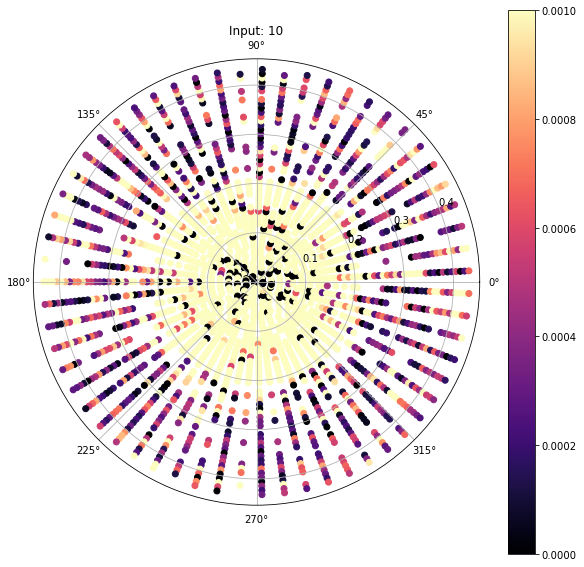

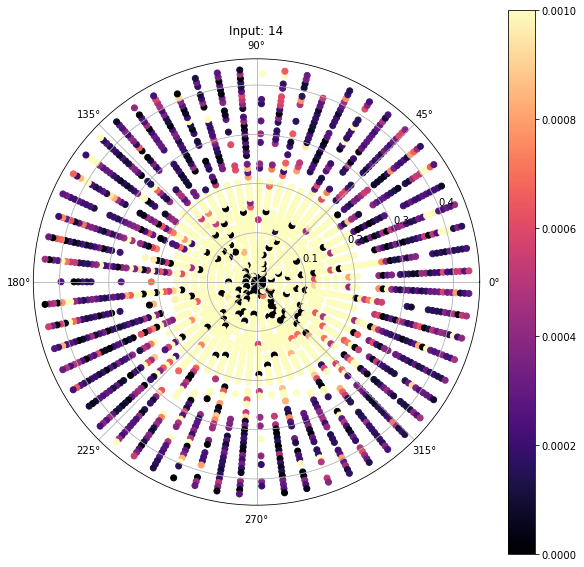

In [16]:
for i,chind in enumerate(E_pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=beam.V_LC_operation_err[:,:,0,chind],vmin=0,vmax=0.001,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

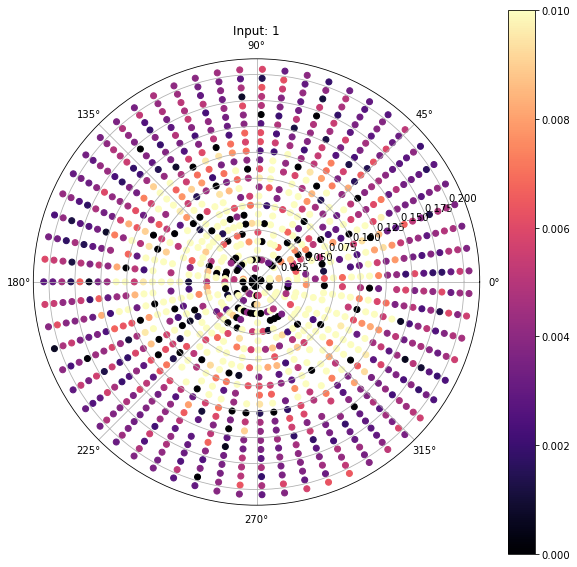

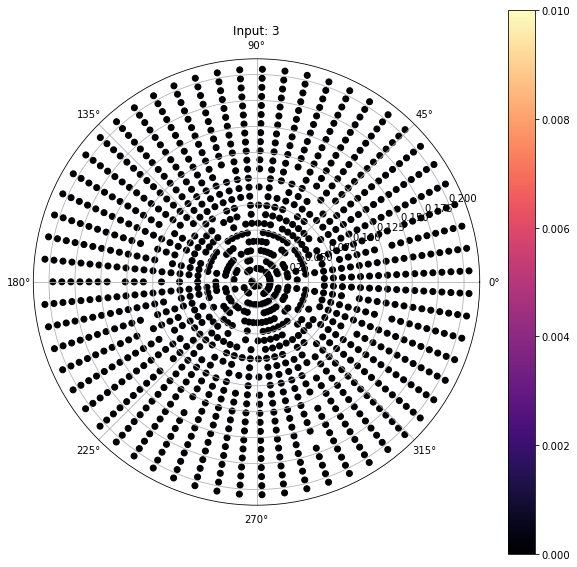

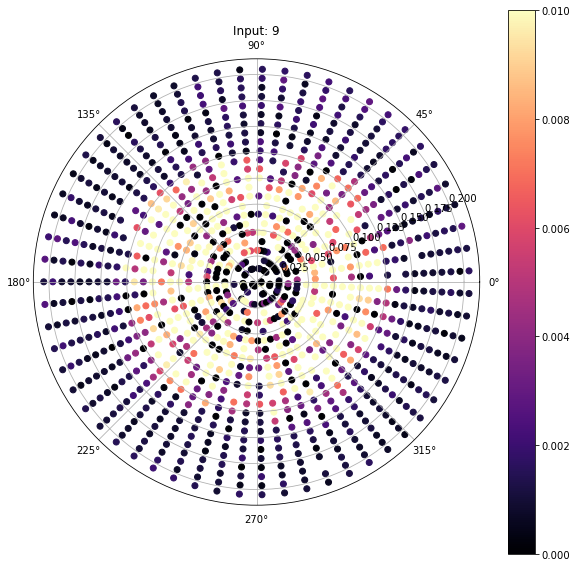

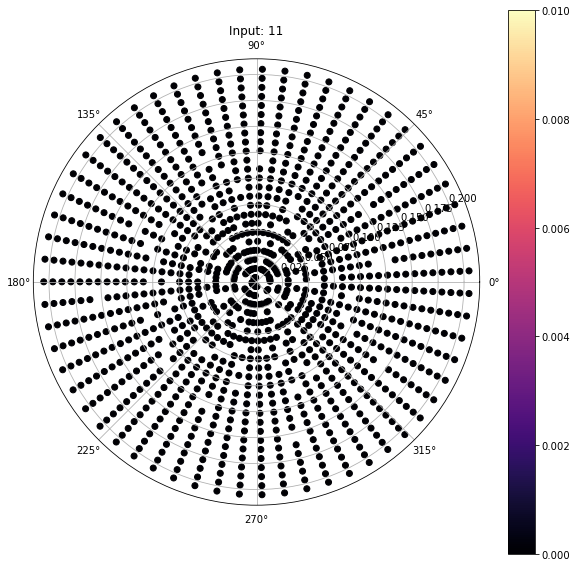

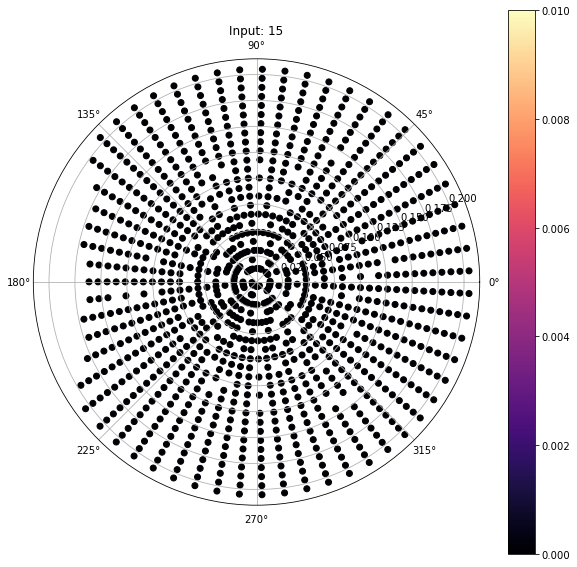

In [12]:
for i,chind in enumerate(N_pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=beam.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [17]:
print(beam.V_LC_operation_err[30,:,0,chind])

[ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  0. nan  0. nan  0. nan  0.  0.
  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
import hdf5plugin
import os
import glob
from matplotlib import colors
import pandas
import csv
import datetime
import pytz
import bisect
import pygeodesy
import yaml
from scipy.signal import square
from scipy.stats import pearsonr
import glob
import pickle
from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

In [ ]:
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))

def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice_old(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

In [4]:


## Class for position-space sorting/averaging of beammap flight data, from time domain data:
#defines coordinate vector from xmax to xmin spaced roughly by xres:
def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)


def get_coord_locs(coordsys,d0args,d1args,n_channels):
    ## Determine Coordinate System: coordsys='cartesian' or 'polar':
    if coordsys=='cartesian':
        Xargs=d0args
        Yargs=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        xedges,yedges=(cedges(Xargs),cedges(Yargs))
        xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges,indexing='ij')
        xcenters,ycenters=(cedges(Xargs)[:-1]+Xargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
        xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(xedges.shape+(n_channels,))
        d1_edges=np.zeros(yedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((xedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((yedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(xcenters.shape+(n_channels,))
        d1_centers=np.zeros(ycenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((xcentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((ycentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=xedges
            d0_centers[:,i]=xcenters
            d1_edges[:,i]=yedges
            d1_centers[:,i]=ycenters
            d0_centers_grid[:,:,i]=xcentersgrid
            d1_centers_grid[:,:,i]=ycentersgrid
            d0_edges_grid[:,:,i]=xedgesgrid
            d1_edges_grid[:,:,i]=yedgesgrid
    if coordsys=='polar':
        theta_args=d0args
        phi_args=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        thetaedges,phiedges=(cedges(theta_args),cedges(phi_args))
        thetaedgesgrid,phiedgesgrid=np.meshgrid(thetaedges,phiedges,indexing='ij')
        thetacenters,phicenters=(cedges(theta_args)[:-1]+theta_args[2]/2.0,cedges(phi_args)[:-1]+phi_args[2]/2.0)
        thetacentersgrid,phicentersgrid=np.meshgrid(thetacenters,phicenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(thetaedges.shape+(n_channels,))
        d1_edges=np.zeros(phiedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((thetaedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((phiedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(thetacenters.shape+(n_channels,))
        d1_centers=np.zeros(phicenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((thetacentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((phicentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=thetaedges
            d0_centers[:,i]=thetacenters
            d1_edges[:,i]=phiedges
            d1_centers[:,i]=phicenters
            d0_centers_grid[:,:,i]=thetacentersgrid
            d1_centers_grid[:,:,i]=phicentersgrid
            d0_edges_grid[:,:,i]=thetaedgesgrid
            d1_edges_grid[:,:,i]=phiedgesgrid    
    return d0_edges, d0_centers, d1_edges, d1_centers, d0_centers_grid, d1_centers_grid, d0_edges_grid, d1_edges_grid                 
    
def get_maskvals(coordsys):
    if coordsys=='cartesian':
        maskin = 18
        maskout = 40
    if coordsys=='polar':
        maskin = 6*np.pi/180.
        maskout = 12*np.pi/180
    return maskin, maskout

        
class Beammap_newnew:
    
    def __init__(self,concatlist=[],#coordsys='cartesian',d0args=[-100,100,5],d1args=[-100,100,5],\
                 coordsys='polar',d0args=[0,360*(np.pi/180.0),6*(np.pi/180.0)],d1args=[0,25*(np.pi/180.0),0.5*(np.pi/180.0)],\
                 Fargs=[0,1024,1],f_index=900,\
                 operation='coadd',inputstyle='pickle',normalization='none',vplot=True,\
                 pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/',\
                 gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',\
                 flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml',\
                 ampcorr_directory='/hirax/GBO_Analysis_Outputs/amplitude_corrections/',\
                 include_cross_data=False,mask=True):
        ## enable format of input to be load from 'pickle' filestring or bin/map using concat 'class':        
        self.normalization = normalization
        self.gfit_directory = gfit_directory
        self.ampcorr_directory = ampcorr_directory  
        self.pickle_directory = pickle_directory
        nchanslist=np.zeros(len(concatlist))

        if inputstyle=='pickle':
            for h,cstring in enumerate(concatlist):
                print(cstring)
                ## using the with loop structure, the pickle file is closed after ccc is loaded:
                with open(cstring, "rb") as f:
                    CONCATCLASS=pickle.load(f)
                nchanslist[h]=CONCATCLASS.n_channels
                self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
        elif inputstyle=='class':
            CONCATCLASS=concatlist[0]
            for h,cstring in enumerate(concatlist):
                nchanslist[h]=cstring.n_channels
                self.FLYNUM=cstring.FLYTAG.split('FLY')[1].split('.')[0]
        ## determine which channel is co-pol, for frequency dependent centroid corrections:
        with open(flightmasterpath, 'r') as flightmaster:
            doccs = yaml.safe_load(flightmaster)
            for j,fstr in enumerate(doccs['flight_info']['flights']):
                if self.FLYNUM in fstr:
                    self.copoldir=doccs['flight_info']['pols'][j]
        #get variables that should be kept along from the first concat class:         
        self.name=CONCATCLASS.name
        self.Data_Directory=CONCATCLASS.Data_Directory
        self.Gain_Directory=CONCATCLASS.Gain_Directory
        self.filenames=CONCATCLASS.filenames
        self.gainfile=CONCATCLASS.gainfile
        self.Drone_Directory=CONCATCLASS.Drone_Directory
        self.FLYTAG=CONCATCLASS.FLYTAG
        self.n_dishes=CONCATCLASS.n_dishes
        self.n_channels=int(np.nanmin(nchanslist))
        self.n_concats=len(concatlist)
        self.chmap=CONCATCLASS.chmap
        self.automap=CONCATCLASS.automap
        self.crossmap=CONCATCLASS.crossmap
        self.origin=CONCATCLASS.origin
        #self.prime_origin=CONCATCLASS.prime_origin ## omit, it breaks the pickle
        self.dish_keystrings=CONCATCLASS.dish_keystrings
        self.dish_coords=CONCATCLASS.dish_coords
        self.dish_pointings=CONCATCLASS.dish_pointings
        self.dish_polarizations=CONCATCLASS.dish_polarizations
        self.fmin,self.fmax,self.fstep=Fargs
        self.faxis=np.arange(self.fmin,self.fmax,self.fstep)
        self.n_freqs=len(self.faxis)
        self.freq=CONCATCLASS.freq[self.faxis]
        find=np.where(self.faxis==f_index)[0][0]
        self.operation=operation
        self.coordsys=coordsys
        
        self.maskin, self.maskout = get_maskvals(coordsys)
        
        (self.d0_edges, self.d0_centers, self.d1_edges, self.d1_centers, 
             self.d0_centers_grid, self.d1_centers_grid, self.d0_edges_grid, 
             self.d1_edges_grid) = get_coord_locs(coordsys,d0args,d1args,self.n_channels)

        ## now need frequency dependent offset terms in shape (freq, channel, concat) to mimic V
        self.x_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))
        self.y_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))        
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_mean=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.V_LC_std=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.histogram_LC=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_sum=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                      self.n_freqs,self.n_channels,self.n_concats))
        self.V_LC_count=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                        self.n_freqs,self.n_channels,self.n_concats))
        
        if include_cross_data==True:
            self.V_LC_cross=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),len(self.crossmap),self.n_concats))
            self.V_LC_cross=self.V_LC_cross.astype(complex) 
            
        print("start of big ass loop is: {}".format(datetime.datetime.now()))
        
        for h,cstring in enumerate(concatlist):
            self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
            
            Vvals, fccoords = self.get_VVals_tempcoords(cstring,h,doccs)
            
            if mask==True: # get mask type for this flight
                arrmask = self.get_mask(doccs,self.FLYNUM)                       

            ## loop through channels (i,chan) to find indices of nonzero cells in histogram
            for i,chan in enumerate(range(self.n_channels)):
                for j,fr in enumerate(self.faxis):
                    print('autos: Concat:{}/{}, Channel:{}/{}, Frequency:{}/{},           '.format(h+1,self.n_concats,i+1,self.n_channels,j+1,len(self.freq)),end='\r')
                    if coordsys=='cartesian':
                        xf,yf=fccoords[i,:,0,j],fccoords[i,:,1,j]
                    elif coordsys=='polar':
                        polcoords=np.array([gu.xyz_to_rpt(fccoords[i,k,:,j]) for k in range(len(fccoords[i,:,:,j]))])
                        xf,yf=polcoords[:,1],polcoords[:,2]                      
                    valsf=Vvals[:,j,i]    
                    
                    #histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
                    self.histogram_LC[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_sum[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='sum',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_count[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    if mask==True:
                        self.V_LC_count[:,:,j,i,h] = np.ma.masked_where(arrmask, 
                                                                self.V_LC_count[:,:,j,i,h]).filled(np.nan) 
                        self.V_LC_sum[:,:,j,i,h] = np.ma.masked_where(arrmask, 
                                                                self.V_LC_sum[:,:,j,i,h]).filled(np.nan) 
                        
        print("end of bigass loop is: {}".format(datetime.datetime.now()))

        # set 0 values to nans for all
        self.V_LC_count[self.V_LC_count == 0] = 'nan'
        self.V_LC_sum[self.V_LC_sum == 0] = 'nan'
        
        if operation=='coadd' or operation=='std': 
            self.V_LC_operation=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_err=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_count=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            
            # average all bins together
            self.V_LC_operation_count = np.nansum(self.V_LC_count,axis=4)
            self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count
            #self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)            
        
        if operation=='std':
            # unfortunately, repeat the above.... assume you're only doing this with pickle files, normalized
            self.V_LC_err=np.NAN*np.ones(self.V_LC_sum.shape)
            
            
            for h,cstring in enumerate(concatlist):
                self.FLYNUM=cstring.split('FLY')[1].split('_')[0]

                ## using the with loop structure, the pickle file is closed after ccc is loaded:
                Vvals, fccoords = self.get_VVals_tempcoords(cstring,h,doccs)
            
                if mask==True: # get mask type for this flight
                    arrmask = self.get_mask(doccs,self.FLYNUM)
            
                ## loop through channels (i,chan) to find indices of nonzero cells in histogram
                for i,chan in enumerate(range(self.n_channels)):
                    for j,fr in enumerate(self.faxis):
                        try:
                            if coordsys=='cartesian':
                                xf,yf=fccoords[i,:,0,j],fccoords[i,:,1,j]
                            elif coordsys=='polar':
                                polcoords=np.array([gu.xyz_to_rpt(fccoords[i,k,:,j]) for k in range(len(fccoords[i,:,:,j]))])
                            xf,yf=polcoords[:,1],polcoords[:,2]  
                            valsf=Vvals[:,j,i]  
                            #print('shape of vvalsf', cstring, i, valsf.shape, xf.shape, yf.shape)
                            #histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
                            binning=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',
                                                    bins=[self.d0_edges[:,i],self.d1_edges[:,i]],
                                                    expand_binnumbers=True).binnumber

                            gbins = np.where((binning[0,:]<len(self.d0_edges[:,i])) & (binning[1,:]<len(self.d1_edges[:,i])))[0]
                            subtracteddata = (valsf[gbins]-self.V_LC_operation[binning[0,gbins]-1,binning[1,gbins]-1,j,i])**2
                            self.V_LC_err[:,:,j,i,h] = binned_statistic_2d(x=xf[gbins],y=yf[gbins],
                                                                    values=subtracteddata,
                                                                    statistic='sum',
                                                                    bins=[self.d0_edges[:,i],
                                                                          self.d1_edges[:,i]]).statistic
                            
  
                            if mask==True:
                                self.V_LC_err[:,:,j,i,h] = np.ma.masked_where(arrmask, self.V_LC_err[:,:,j,i,h]).filled(np.nan) 
        
                        except: print('noooooooooo')
            
            self.V_LC_operation_err = (np.nansum(self.V_LC_err,axis=4)/self.V_LC_operation_count)**0.5 # stddev
        
        
        
                
        print("end of concat loop is: {}".format(datetime.datetime.now()))
                                
    def get_mask(self,doccs,flynum):

        for j,fstr in enumerate(doccs['flight_info']['flights']): # what mask
                if flynum in fstr: maskit = doccs['flight_info']['masks'][j]
                    
        if self.coordsys == 'cartesian':
            if maskit=='inner':
                thingyx = np.ma.masked_inside(self.d0_centers_grid[:,:,0], -1*self.maskin, self.maskin, copy=True)
                thingyy = np.ma.masked_inside(self.d1_centers_grid[:,:,0], -1*self.maskin, self.maskin, copy=True)
                arrmask = np.logical_and(thingyx.mask,thingyy.mask)
            elif maskit=='outer':
                thingyx = np.ma.masked_inside(self.d0_centers_grid[:,:,0], -1*self.maskout, self.maskout, copy=True)
                thingyy = np.ma.masked_inside(self.d1_centers_grid[:,:,0], -1*self.maskout, self.maskout, copy=True)
                thingy = np.logical_and(thingyx.mask,thingyy.mask)
                arrmask = np.logical_not(thingy)
        elif self.coordsys == 'polar':
            if maskit=='inner':
                arrmask = np.ma.masked_inside(self.d1_centers_grid[:,:,0], 0, self.maskin, copy=True).mask
            elif maskit=='outer':
                thingyr = np.ma.masked_inside(self.d1_centers_grid[:,:,0], 0, self.maskout, copy=True).mask
                arrmask = np.logical_not(thingyr)            
        return arrmask
    
    
    def get_VVals_tempcoords(self,cstring,h,doccs):
                
        for j,fstr in enumerate(doccs['flight_info']['flights']):
            if self.FLYNUM in fstr:
                self.copoldir=doccs['flight_info']['pols'][j]
                    
        ## using the with loop structure, the pickle file is closed after ccc is loaded:
        with open(cstring, "rb") as f:
            ccc=pickle.load(f)   
        t_cut=ccc.inds_on
        
        if self.normalization=='none':
            Vvals=ccc.V_bgsub[ccc.inds_on,:,:]
            
        if self.normalization=='Gauss' or self.normalization=='Gauss_wcorr':
            # get the normalization:
            gfit=glob.glob(self.gfit_directory+'*'+self.FLYNUM+'*.npz')[0]
            print(self.FLYNUM,gfit)
            gff = np.load(gfit)
            g_norm=gff['G_popt'][:,:,0]
            Vvals=(np.repeat(
                np.swapaxes(g_norm[:,self.fmin:self.fmax:self.fstep],0,1)[np.newaxis,:,:],len(ccc.inds_on),axis=0)**-1)*ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]       
                
            for i in range(self.n_channels):
                if self.copoldir in 'E':
                    COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][0]
                    self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                    self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
                elif self.copoldir in 'N':
                    COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][1]
                    self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                    self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
                                
                                                
        if self.normalization=='Gauss_wcorr':
            gcorrfile=glob.glob(self.ampcorr_directory+'*'+self.FLYNUM+'*.pkl')[0]
            with open(gcorrfile,'rb') as acf:
                gcorr_norm=pickle.load(acf)
            Vvals *= gcorr_norm[0,self.faxis,:][np.newaxis,:,:]
                            
        ## create centroid-corrected per channel and frequency drone coordinate maps on a per-concat basis:
        tmpcoords=np.repeat(ccc.drone_xyz_per_dish_interp[:,:,:,np.newaxis],self.n_freqs,axis=3)
        shiftvec=np.array((self.x_offsets[:,:,h],self.y_offsets[:,:,h],np.zeros(self.x_offsets[:,:,h].shape)))
        tmpshifts=np.repeat(np.swapaxes(np.swapaxes(shiftvec,0,2),1,2)[:,np.newaxis,:,:],len(ccc.t),axis=1)
        fccoords=(tmpcoords-tmpshifts)[:,ccc.inds_on]
                
        return Vvals,fccoords 
                


Working on Frequency:  900 448.4375
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY647_20211022T185749Z_ver_20231012T025038_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY533_20210826T182904Z_ver_20231012T224133_concat.pkl
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20231012T001328_concat.pkl
start of big ass loop is: 2023-11-21 22:55:36.486696
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
625 /hirax/GBO_Analysis_Out

<ipython-input-4-9a8a7aea835c>:206: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 0 (9377,) (9377,) (9377,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 1 (9377,) (9377,) (9377,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 2 (9377,) (9377,) (9377,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 3 (9377,) (9377,) (9377,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 4 (9377,) (9377,) (9377,)
noooooooooo
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl 5 (9377,) (9377,) (9377,)
noooooooooo
shape of vvalsf /hirax/GBO_Analysis_O

shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 8 (11293,) (11293,) (11293,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 9 (11293,) (11293,) (11293,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 10 (11293,) (11293,) (11293,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 11 (11293,) (11293,) (11293,)
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 12 (11293,) (11293,) (11293,)
noooooooooo
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 13 (11293,) (11293,) (11293,)
noooooooooo
shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl 

shape of vvalsf /hirax/GBO_Analysis_Outputs/flight_pickles/FLY536_20210826T195003Z_ver_20231012T001328_concat.pkl 15 (9582,) (9582,) (9582,)
end of concat loop is: 2023-11-21 22:56:29.209872


<ipython-input-4-9a8a7aea835c>:253: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation_err = (np.nansum(self.V_LC_err,axis=4)/self.V_LC_operation_count)**0.5 # stddev


DONE
For loop ended successfully


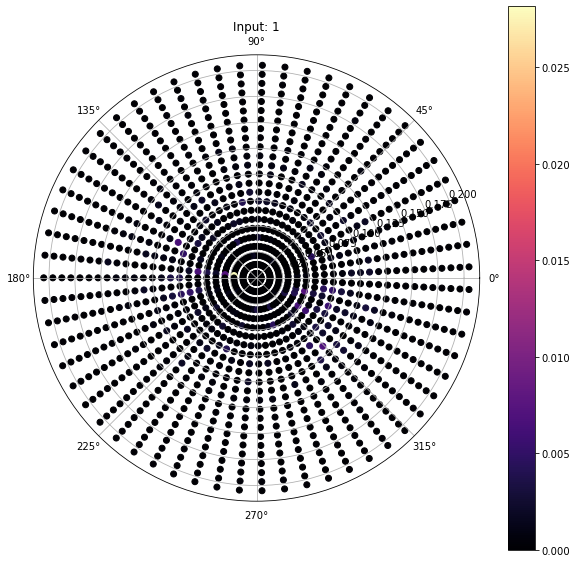

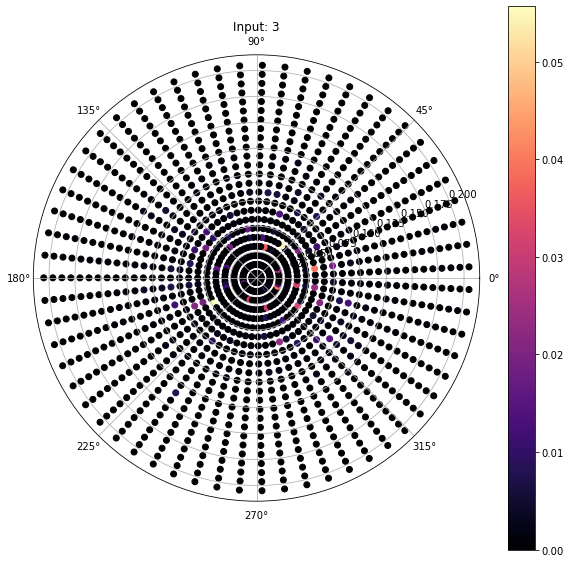

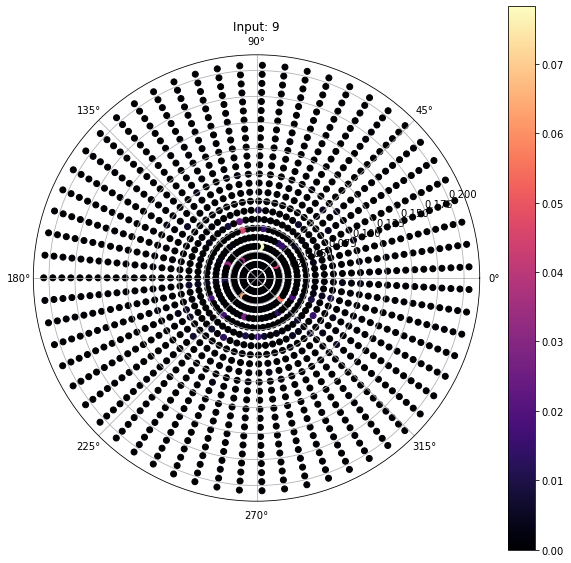

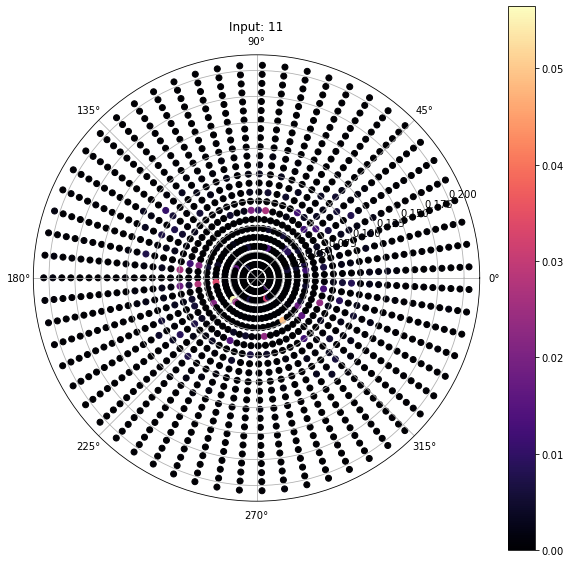

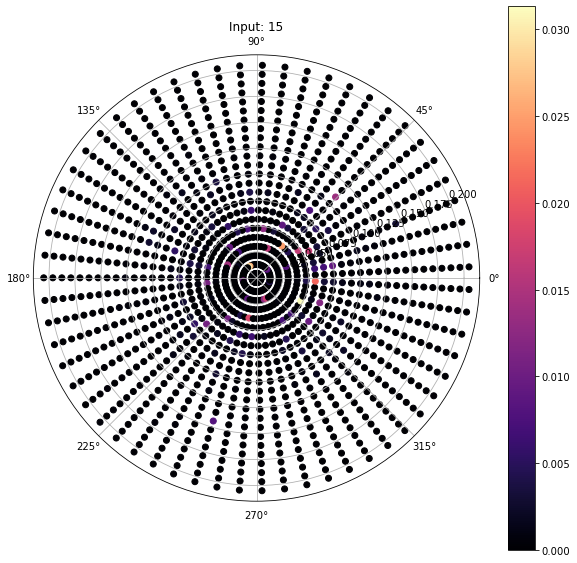

In [5]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

for find in good_freqs[115:116]:
    print('Working on Frequency: ',find,freqs[find])
    
    flights = Npolflights
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in flights]    

    beam=Beammap_newnew(concatlist=concytest,
                 coordsys='polar',normalization='Gauss_wcorr',operation='std',Fargs=[find,find+1,1],
                    f_index=find,vplot=False,mask=True)
    print('DONE')
print('For loop ended successfully')

for i,chind in enumerate(N_pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=beam.V_LC_err[:,:,0,chind,1],cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

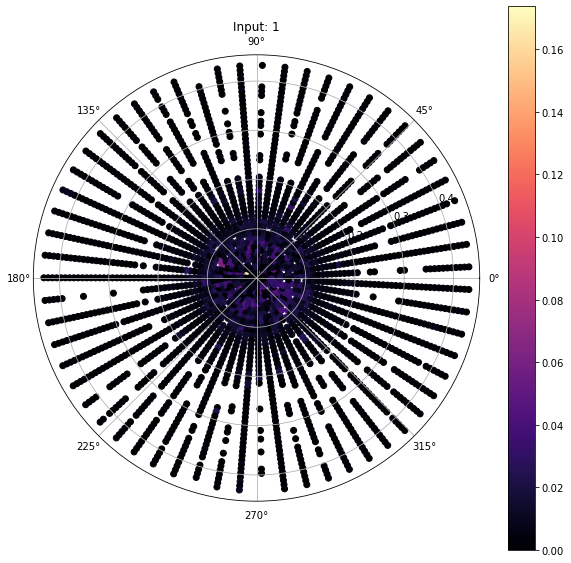

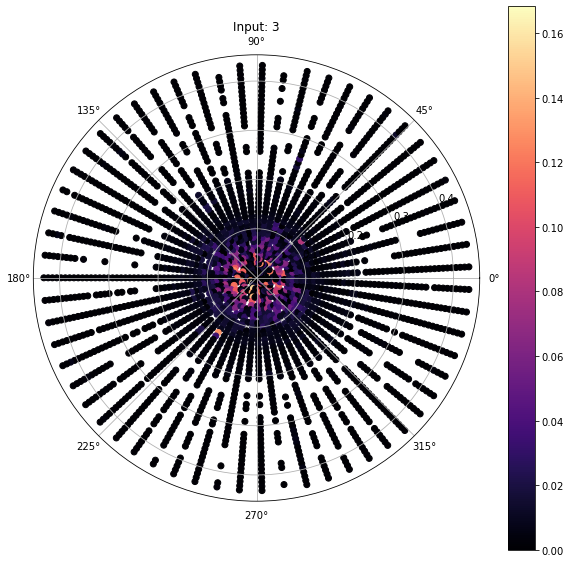

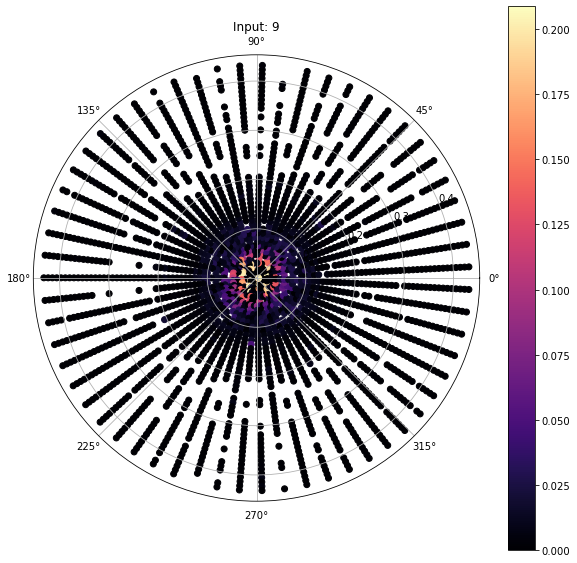

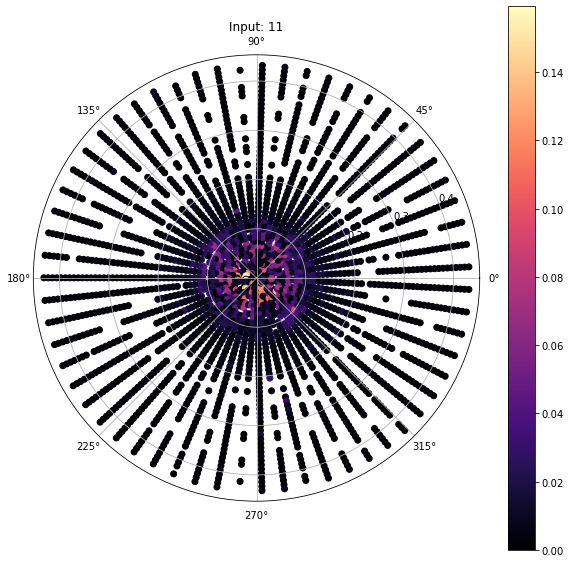

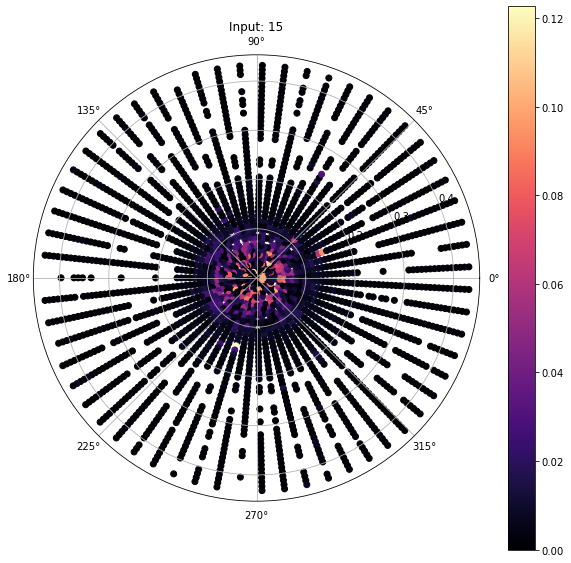

In [6]:
for i,chind in enumerate(N_pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=beam.V_LC_operation_err[:,:,0,chind],cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [39]:
59*50

2950

In [ ]:
Npolflights = ['618','619','623','625','646','647','533','536']
Epolflights = ['620','648','649','535']

pflights=Npolflights
find=900

for i, fly in enumerate(pflights[6:7]):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=Beammap_newnew(concatlist=concytest[fi],
                 coordsys='polar',normalization='Gauss_wcorr',operation='coadd',Fargs=[find,find+1,1],
                    f_index=find,vplot=False,mask=True)

chind = 1
plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
             beam.V_LC_operation[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()

In [ ]:
flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml'
with open(flightmasterpath, 'r') as flightmaster:
    doccs = yaml.safe_load(flightmaster)

for j,fstr in enumerate(doccs['flight_info']['flights']): # what mask
    if beam.FLYNUM in fstr: maskit = doccs['flight_info']['masks'][j]
        
print(maskit)

arrmask = beam.get_mask(doccs,'533')

#print(arrmask.shape)

x = beam.d0_centers_grid[:,:,chind]
y = beam.d1_centers_grid[:,:,chind]

#arrmask = np.ma.masked_inside(beam.d1_centers_grid[:,:,0], 0.0, 0.1, copy=True)


ss_s = np.ma.masked_where(arrmask,
                                beam.V_LC_sum[:,:,0,chind,0]).filled(-1)
ss_c = np.ma.masked_where(arrmask,
                                beam.V_LC_count[:,:,0,chind,0]).filled(-1)

plt.scatter(x,y,c=ss_s)
plt.colorbar()
plt.show()

#fig = plt.figure(figsize=(10,10))
#
#ax = plt.subplot(1, 1, 1, projection='polar')
#plt.scatter(x,y,
#               c=beam.V_LC_sum[:,:,0,chind,0])#,vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
#plt.title('Input: '+str(chind))
#plt.colorbar()
#plt.show()

In [ ]:
tt = np.nansum(beam.V_LC_sum,axis=4)/np.nansum(beam.V_LC_count,axis=4)
tt = beam.V_LC_sum
print(tt.shape)
plt.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
             tt[:,:,0,chind,0],cmap=cm.inferno)#,edgecolors='k')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()



In [ ]:
for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    x = beam.d0_centers_grid[:,:,chind]
    y = beam.d1_centers_grid[:,:,chind]
    ax = plt.subplot(1, 1, 1, projection='polar')
    plt.scatter(x,y,
               c=10*np.log10(np.abs(beam.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

In [ ]:
Npolflights = ['618','619','623','625','646','647','533','536']
Epolflights = ['620','648','649','535']

pflights=Npolflights[::2]
find=900

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in pflights]
print(concytest)


beam=Beammap_newnew(concatlist=concytest,
                 coordsys='polar',normalization='Gauss_wcorr',operation='std',Fargs=[find,find+1,1],
                    f_index=find,vplot=False,mask=True)

chind = 1
fig = plt.figure(figsize=(10,10))
x = beam.d0_centers_grid[:,:,chind]
y = beam.d1_centers_grid[:,:,chind]
ax = plt.subplot(1, 1, 1, projection='polar')
plt.scatter(x,y,
               c=10*np.log10(np.abs(beam.V_LC_operation[:,:,0,chind])),vmax=1.0,vmin=-40,cmap=cm.magma)#,edgecolors='k')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()


    
    


In [ ]:
chind = 1
fig = plt.figure(figsize=(10,10))
x = beam.d0_centers_grid[:,:,chind]
y = beam.d1_centers_grid[:,:,chind]
ax = plt.subplot(1, 1, 1, projection='polar')
plt.scatter(x,y,
               c=10*np.log10(np.abs(beam.V_LC_operation_err[:,:,0,chind])),vmax=-5,vmin=-25,cmap=cm.magma)#,edgecolors='k')
plt.title('Input: '+str(chind))
plt.colorbar()
plt.show()